# Comparing Classification Models
In this notebook, we'll be comparing three classification models: Decision Tree, Random Forest, and SVM. We'll evaluate each model's performance using classification report, confusion matrix, ROC curve, and other visualization techniques.


# 1. Import necessary libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, make_scorer, f1_score
from pathlib import Path

# 2. Load and Split the Data
We import the final datasets used for training, testing, and validation. Stored in pickle files, the file for the Dynamic Rollover is at path `data/dynamic_rollover_pandas_2.0.2.pkl`. For more information on how this dataset was selected and prepared please see the `README` and the `preprocess_datasets.py`

In [2]:
# this is the path to your pickle file (should be the same location as CSVs)
path = Path('data')

with open(path / 'dynamic_rollover_pandas_2.0.2.pkl', 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

In [3]:
# define independent variables and dependent variable
maneuver = 'Dynamic Rollover'
X = df.drop(maneuver, axis=1)
y = df[maneuver]

In [4]:
# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Model Training & Predictions
Here, we'll define, train, and generate predictions for each model using the given configurations.

## Implementing Grid Search with Stratified K-Fold and Preprocessing
In this section, we will perform hyperparameter tuning using Grid Search along with Stratified K-Fold cross-validation. For the SVM model, we'll also add a preprocessing step with StandardScaler.


In [5]:
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score)

## Hyperparameter tuning using GridSearchCV.

In [6]:
# decision tree
dt_params_grid = {
    'max_depth': [None],
    'min_samples_split': [5],
    'criterion': ['entropy'],
    'splitter': ['best'],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'random_state': [42]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_params_grid, cv=strat_kfold, n_jobs=-1, scoring=f1_scorer)
dt_grid_search.fit(X_train, y_train)

# Random Forest
rf_params_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['log2'],
    'bootstrap': [False],
    'class_weight': ['balanced'],
    'random_state': [42],
    'n_jobs': [-1]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_params_grid, cv=strat_kfold, n_jobs=-1, scoring=f1_scorer)
rf_grid_search.fit(X_train, y_train)

# SVM with pipeline (for scaling)
svm_params_grid = {
    'svm__gamma': [1],
    'svm__C': [1000],
    'svm__kernel': ['rbf'],
    'svm__class_weight': ['balanced'],
    'svm__random_state': [42]
}

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

svm_grid_search = GridSearchCV(svm_pipeline, svm_params_grid, cv=strat_kfold, n_jobs=-1, scoring=f1_scorer)
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svm__C': [1000], 'svm__class_weight': ['balanced'],
                         'svm__gamma': [1], 'svm__kernel': ['rbf'],
                         'svm__random_state': [42]},
             scoring=make_scorer(f1_score))

## Evaluating Best Models
We'll visualize the performance metrics of each model using classification report, confusion matrix, and other visualizations.

In [7]:
dt_best = dt_grid_search.best_estimator_
rf_best = rf_grid_search.best_estimator_
svm_best = svm_grid_search.best_estimator_

dt_preds = dt_best.predict(X_test)
rf_preds = rf_best.predict(X_test)
svm_preds = svm_best.predict(X_test)

### Classification Report

In [8]:
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_preds))

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_preds))

print("\nSVM Classification Report:")
print(classification_report(y_test, svm_preds))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51270
           1       1.00      0.99      1.00       511

    accuracy                           1.00     51781
   macro avg       1.00      1.00      1.00     51781
weighted avg       1.00      1.00      1.00     51781


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51270
           1       1.00      0.99      1.00       511

    accuracy                           1.00     51781
   macro avg       1.00      1.00      1.00     51781
weighted avg       1.00      1.00      1.00     51781


SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51270
           1       0.92      0.99      0.96       511

    accuracy                           1.00     51781
   macro avg       0.96  

### Confusion Matrix

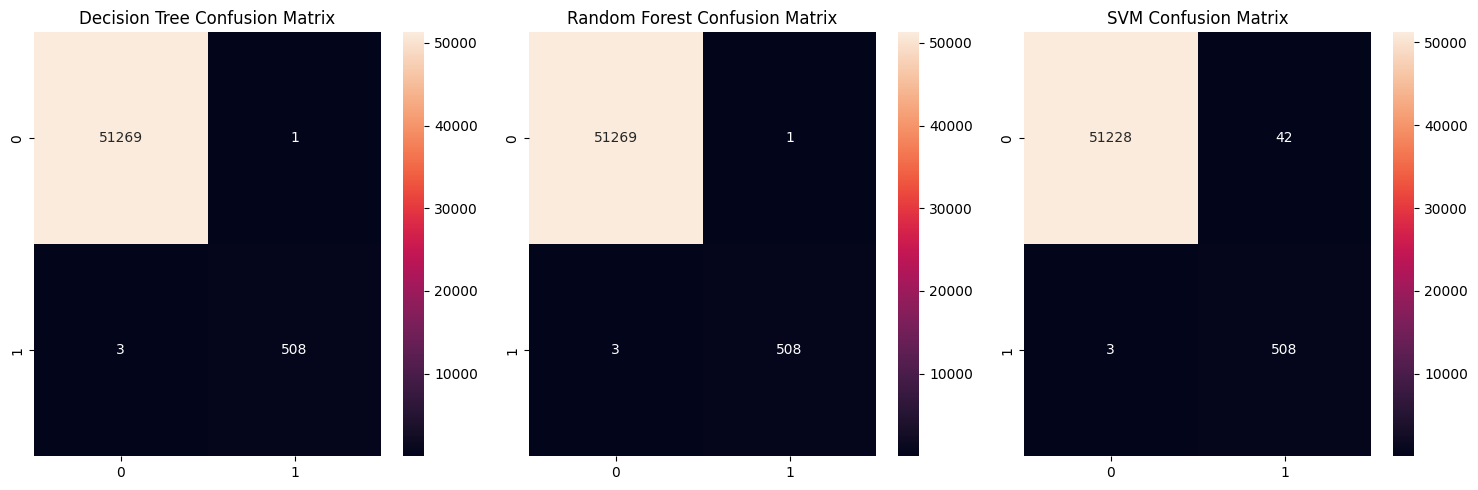

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.heatmap(confusion_matrix(y_test, dt_preds), annot=True, ax=axes[0], fmt="g")
axes[0].set_title('Decision Tree Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, ax=axes[1], fmt="g")
axes[1].set_title('Random Forest Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, svm_preds), annot=True, ax=axes[2], fmt="g")
axes[2].set_title('SVM Confusion Matrix')

plt.tight_layout()
plt.show()


### ROC Curve

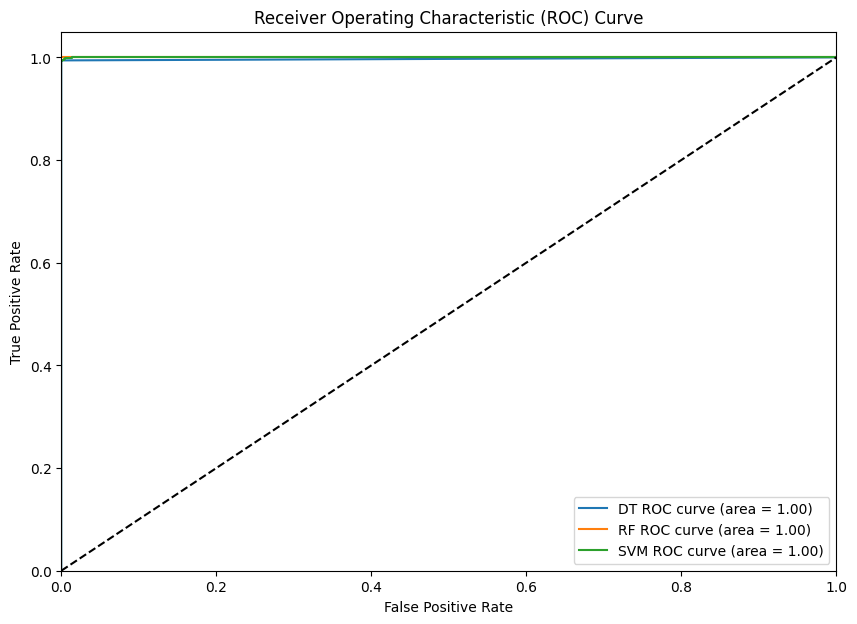

In [10]:
# For demonstration purposes, here's an example for binary classification.

# Decision Tree ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_best.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Random Forest ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_best.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# SVM ROC Curve
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_best.predict_proba(X_test)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(10, 7))
plt.plot(fpr_dt, tpr_dt, label=f'DT ROC curve (area = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF ROC curve (area = {roc_auc_rf:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC curve (area = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Bar chart of all models F1, Recall, and Precision

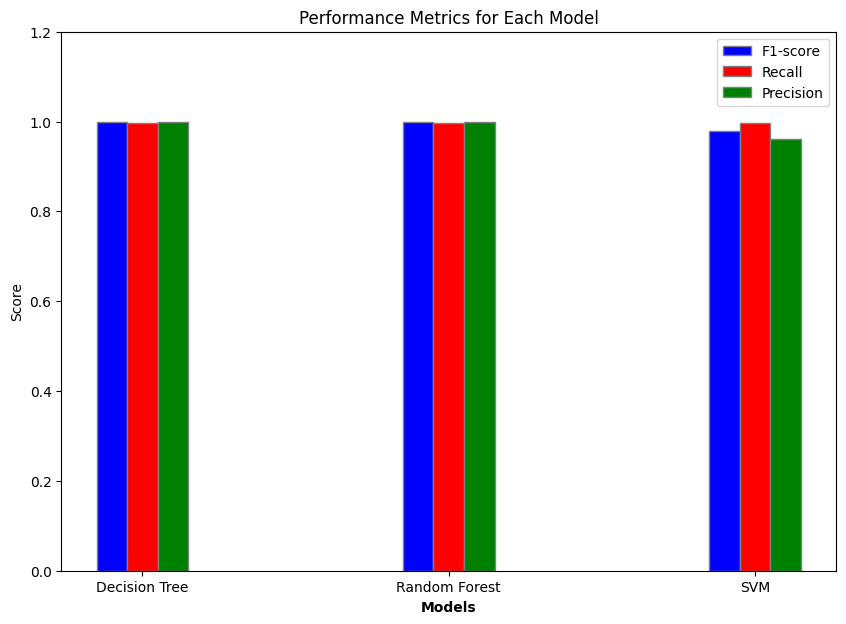

In [11]:
models = ['Decision Tree', 'Random Forest', 'SVM']
f1_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['f1-score'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['f1-score'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['f1-score']
]
recall_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['recall'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['recall'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['recall']
]
precision_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['precision'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['precision'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['precision']
]

barWidth = 0.1
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(10, 7))

plt.bar(r1, f1_scores, color='blue', width=barWidth, edgecolor='grey', label='F1-score')
plt.bar(r2, recall_scores, color='red', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, precision_scores, color='green', width=barWidth, edgecolor='grey', label='Precision')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(f1_scores))], models)

# Create legend & Show graphic
plt.legend()
plt.title('Performance Metrics for Each Model')
plt.ylabel('Score')
plt.ylim(0, 1.2)  # Assuming the metrics are between 0 and 1

plt.show()

Looking closer:

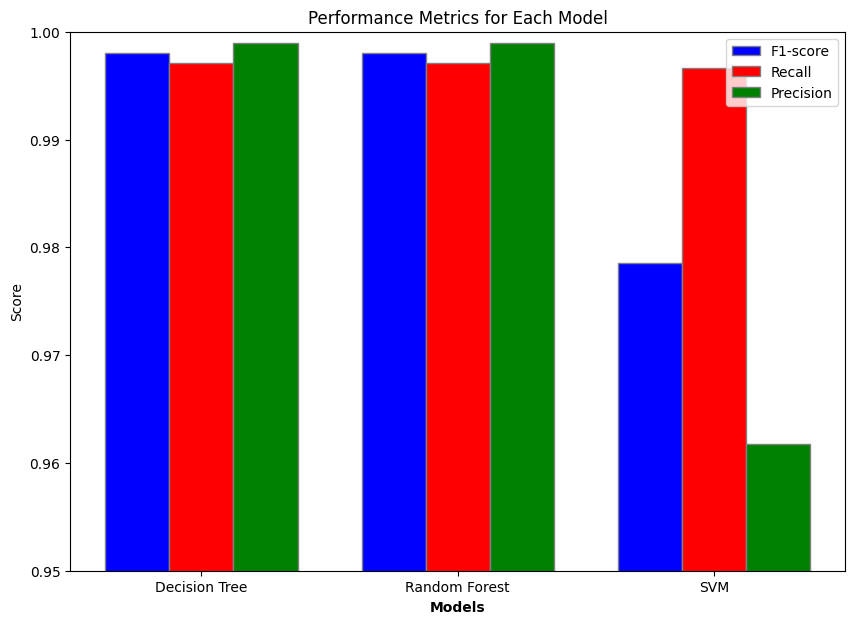

In [12]:
models = ['Decision Tree', 'Random Forest', 'SVM']
f1_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['f1-score'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['f1-score'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['f1-score']
]
recall_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['recall'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['recall'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['recall']
]
precision_scores = [
    classification_report(y_test, dt_preds, output_dict=True)['macro avg']['precision'],
    classification_report(y_test, rf_preds, output_dict=True)['macro avg']['precision'],
    classification_report(y_test, svm_preds, output_dict=True)['macro avg']['precision']
]

barWidth = 0.25
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(10, 7))
plt.bar(r1, f1_scores, color='blue', width=barWidth, edgecolor='grey', label='F1-score')
plt.bar(r2, recall_scores, color='red', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, precision_scores, color='green', width=barWidth, edgecolor='grey', label='Precision')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(f1_scores))], models)

# Create legend & Show graphic
plt.legend()
plt.title('Performance Metrics for Each Model')
plt.ylabel('Score')
plt.ylim(0.95, 1)  # Assuming the metrics are between 0 and 1

plt.show()


We will look at the Learning Curve for Decision Trees and Random Forest to determine which model performs best throughout the training process.

In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, xlim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(20, 14))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

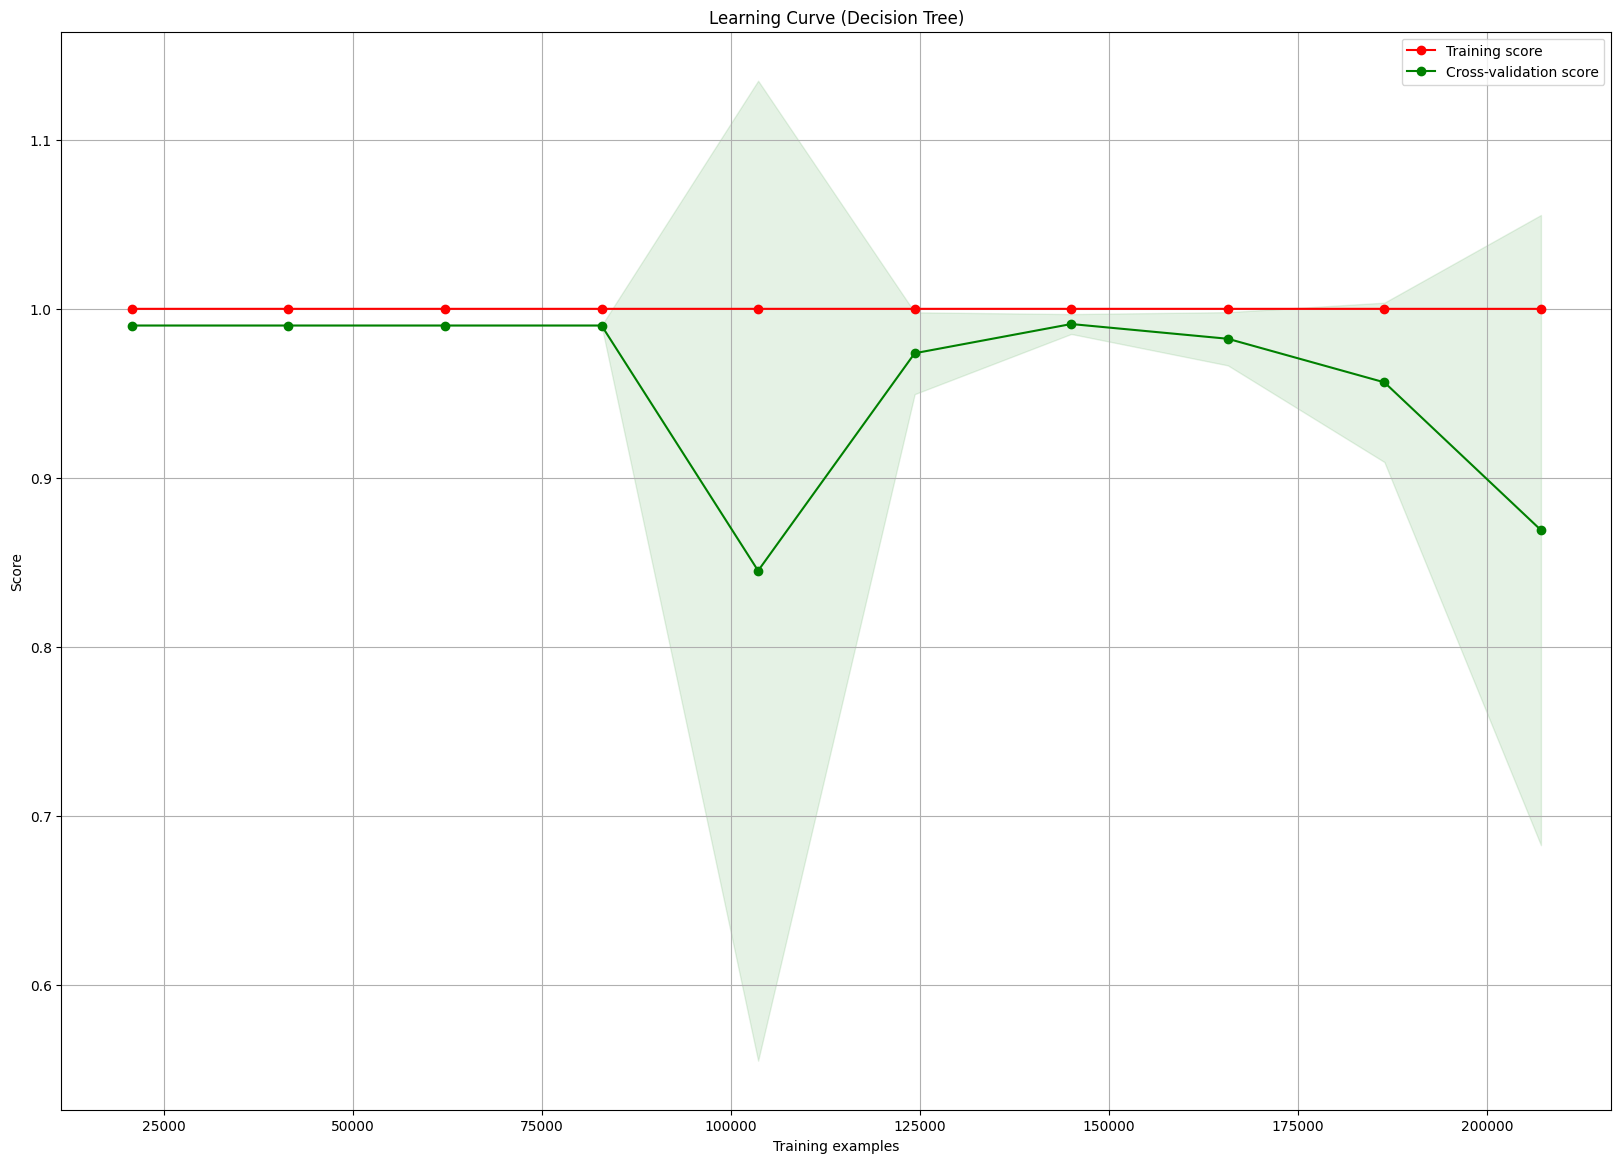

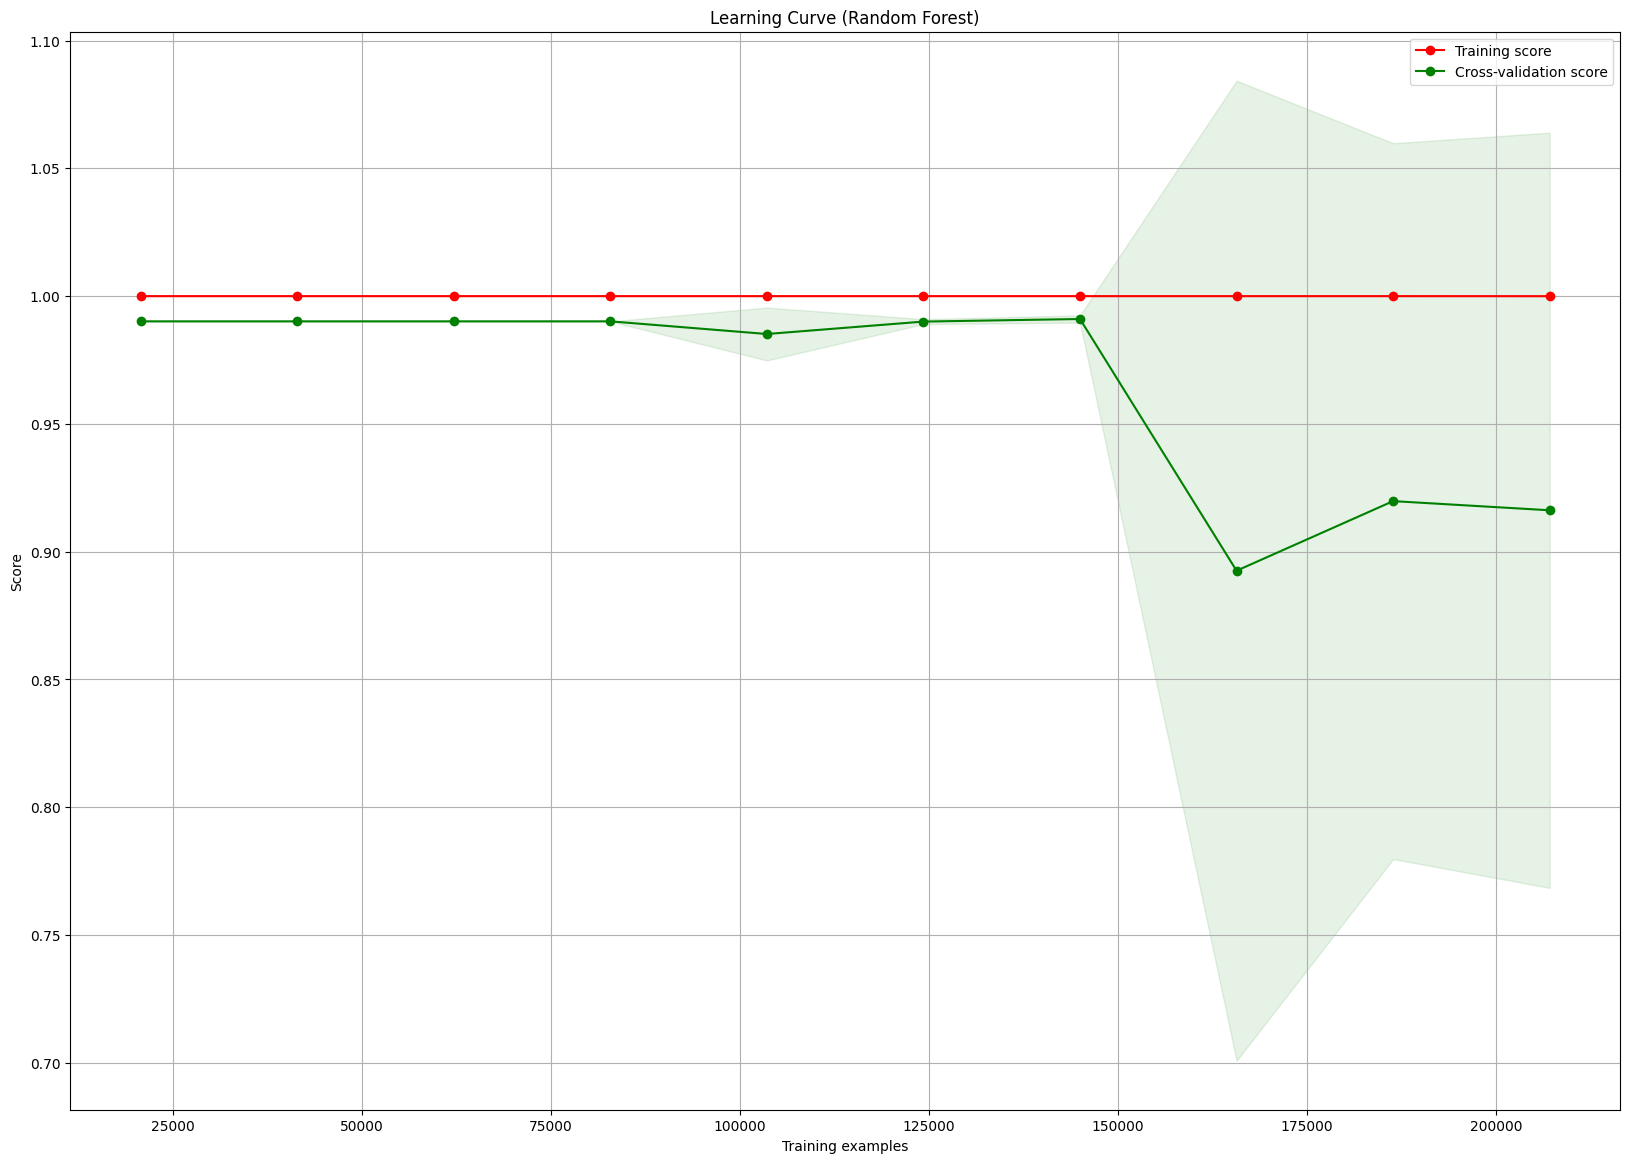

In [14]:
# For Decision Tree
plot_learning_curve(dt_best, "Learning Curve (Decision Tree)", X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# For Random Forest
plot_learning_curve(rf_best, "Learning Curve (Random Forest)", X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))
plt.show()

Decision Tree and Random Forest seem to perform equally. We will look at the top performing features in each as our findings:

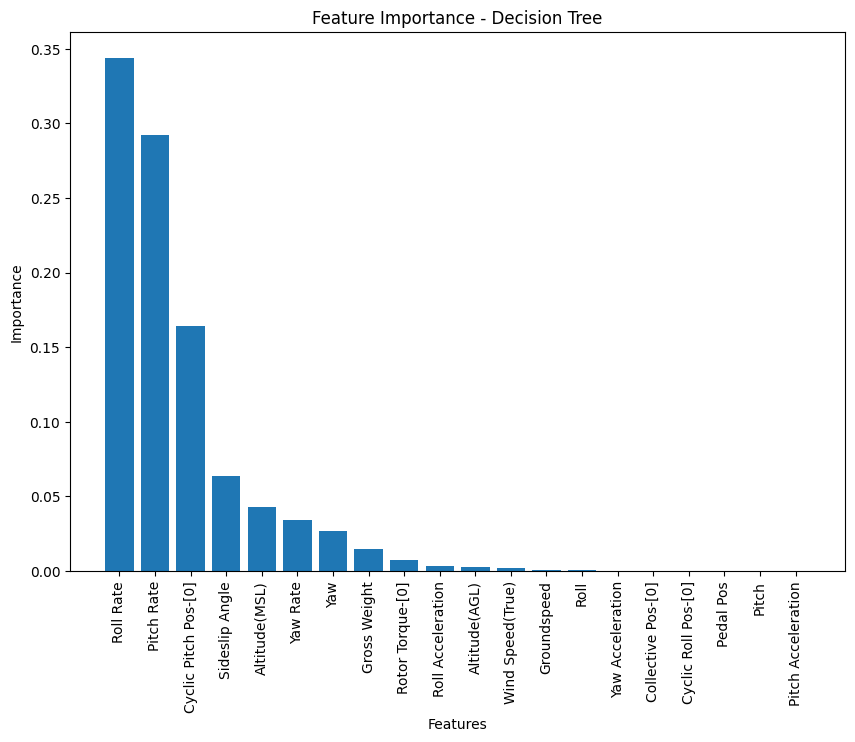

In [15]:
# get importance
dt_importance = dt_best.feature_importances_

# summarize feature importance
sorted_idx_dt = dt_importance.argsort()[::-1]  # the most important feature is first

# plot feature importance
plt.figure(figsize=(10, 7))
plt.title('Feature Importance - Decision Tree')
plt.bar(range(X_test.shape[1]), dt_importance[sorted_idx_dt], align='center')
plt.xticks(range(X_test.shape[1]), [X_test.columns[i] for i in sorted_idx_dt], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


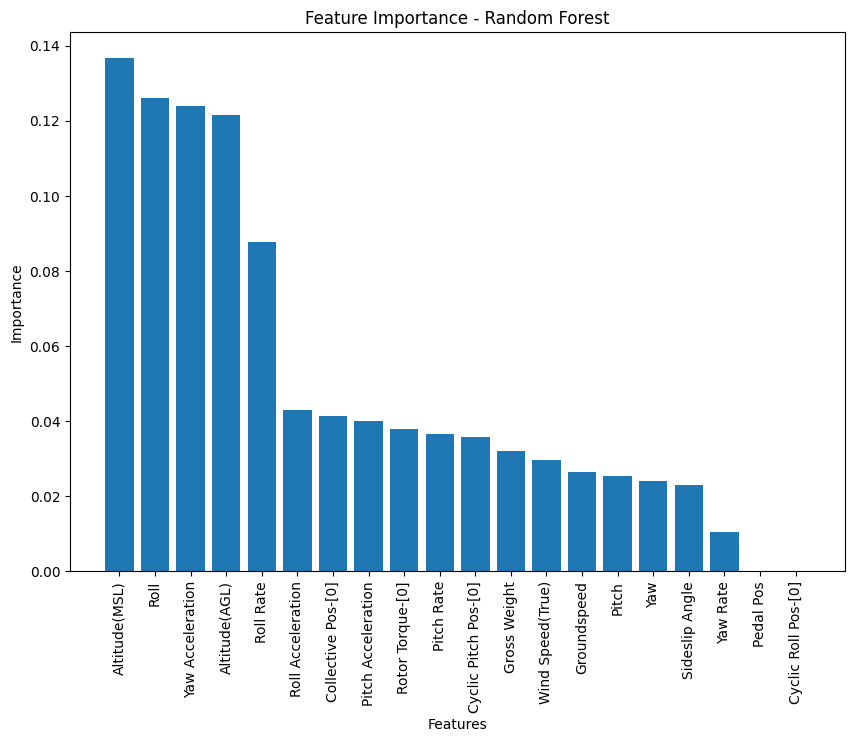

In [16]:
# get importance
rf_importance = rf_best.feature_importances_

# summarize feature importance
sorted_idx_rf = rf_importance.argsort()[::-1]  # the most important feature is first

# plot feature importance
plt.figure(figsize=(10, 7))
plt.title('Feature Importance - Random Forest')
plt.bar(range(X_test.shape[1]), rf_importance[sorted_idx_rf], align='center')
plt.xticks(range(X_test.shape[1]), [X_test.columns[i] for i in sorted_idx_rf], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()